# IMDB Movie reviews sentiment classification

## 0. Settings

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Load dataset

In [3]:
!ls

9413016_HW5.pdf                         Telco Customer Churn.csv
Genetic Algorithm.ipynb                 imdb_labelled.csv
HW5.pages                               raymer2000.pdf
HW5.pdf                                 roc.png
NaïveBayes & LogisticRegression.ipynb


In [4]:
PATH = './'
DATA_FILE = 'imdb_labelled.csv'

In [5]:
data = pd.read_csv(PATH + DATA_FILE, delimiter='\t', header=None,
                   names=['Text', 'Sentiment'])
data.head()

,Text,Sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


### 1.2 Clean text

In [6]:
import nltk
nltk.download('stopwords');
nltk.download('punkt');

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>


In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
import string

def Text_Preprocess(df, col):
    # remove html tags (safe)
    df[col] = df[col].apply(lambda text: BeautifulSoup(text).get_text())
    
    # remove punctuation and numbers
    df[col] = df[col].str.translate(str.maketrans('', '', string.punctuation + string.digits))
    
    stop = set(stopwords.words('english')) # stopwords 
    st = PorterStemmer() # Porter Stemming Algorithm
    
    # Tokenize - Stem - Remove stop words and whitespace
    df[col] = df[col].apply(lambda text: 
                            [st.stem(w.strip()) for w in word_tokenize(text.lower()) if w not in stop])
    
    # Common word removal
    freq = pd.Series([w for rw in df[col] for w in rw]).value_counts()[:2]
    # df[col] = df[col].apply(lambda text: [w for w in text if w not in freq.index])
    

In [8]:
Text_Preprocess(data, 'Text')
data.head()

,Text,Sentiment
0,"[slowmov, aimless, movi, distress, drift, youn...",0
1,"[sure, lost, flat, charact, audienc, nearli, h...",0
2,"[attempt, arti, black, white, clever, camera, ...",0
3,"[littl, music, anyth, speak]",0
4,"[best, scene, movi, gerardo, tri, find, song, ...",1


## 2. Train models

### 2.1 Naive Bayes classifier

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB


# Split data to train/test sets
X_train, X_test, y_train, y_test = train_test_split(data['Text'], data['Sentiment'])


# Calculate TF-IDF matrix
dummy = lambda doc: doc
tfidf = TfidfVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
    token_pattern=None)
train_tf_idf = tfidf.fit_transform(X_train) 
test_tf_idf = tfidf.transform(X_test)


# Naive Bayes classifier for multinomial models
clf_nb = MultinomialNB()    
clf_nb.fit(train_tf_idf, y_train)


# Predict results
train_result = clf_nb.predict(train_tf_idf)
test_result = clf_nb.predict(test_tf_idf)


# Calcualte accuracy scores
train_score = accuracy_score(y_train, train_result) 
test_score = accuracy_score(y_test, test_result)    
totalNB = confusion_matrix(y_train, train_result)

print(f'Training accuracy: {train_score}\nTest accuracy: {test_score}')

Training accuracy: 0.9786096256684492
Test accuracy: 0.7754010695187166


### 2.2 Logisitc Regression

In [10]:
from sklearn.linear_model import LogisticRegression

# Logistic regression model
clf_lg = LogisticRegression(solver='lbfgs').fit(train_tf_idf, y_train)


# Predict results
train_result = clf_lg.predict(train_tf_idf)
test_result = clf_lg.predict(test_tf_idf)


# Calcualte accuracy scores
train_score = accuracy_score(y_train, train_result) 
test_score = accuracy_score(y_test, test_result)    


print(f'Training accuracy: {train_score}\nTest accuracy: {test_score}')

Training accuracy: 0.9786096256684492
Test accuracy: 0.7807486631016043


## 3. Plot and Analysis 

### 3.1 Roc curve

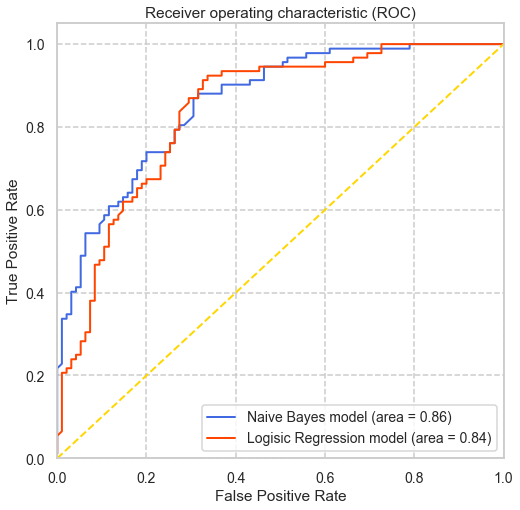

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

sns.set('talk', 'whitegrid', 'dark', font_scale=0.85,
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})


''' plotting multi-class roc curve'''
# predict probabilities
y_pred_nb = clf_nb.predict_proba(test_tf_idf)
y_pred_lg = clf_lg.predict_proba(test_tf_idf)


# plot
fig = plt.figure(figsize=(8,8))

for y_pred, name, cl in ((y_pred_nb, 'Naive Bayes model', 'royalblue'), 
                         (y_pred_lg, 'Logisic Regression model', 'orangered')):
    fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=cl, 
             lw=2, label=f'{name} (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='gold', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig(PATH + 'roc.png')
plt.show()

### 3.2 Analysis

<div style="text-align: right">
همانطور که در نمودار مشاهده می‌شود، مدل بیز بهتر است.





</div>